In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [3]:
os.chdir('..')

In [4]:
## Which PGN File To Train
max_games = 500000
asset_dir = 'asset'
file_name = '2023_tc_50000_games.pgn'

In [5]:
gauth = GoogleAuth()
gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("mycreds.txt")
drive = GoogleDrive(gauth)

In [6]:
max_games = 500000 
asset_dir = 'asset'
file_name = '2023_tc_50000_games.pgn'

cached_urls_file = file_name.split('.')[0] + '_urls_list.pkl'
cached_ratings_file = file_name.split('.')[0] + '_ratings_list.pkl'
cached_games_file = file_name.split('.')[0] + '_game_arrays.pkl'

In [7]:
def load_item_from_file(file_path):
    if os.path.exists(file_path):
        print('loading item from cache...')
        with open(file_path, 'rb') as file:
            items = pickle.load(file)
        print('loaded')
        return items
    else:
        return None

try:
    assets_path = os.path.join(os.getcwd(), asset_dir)
    cached_urls_path = os.path.join(assets_path, cached_urls_file)
    cached_ratings_path = os.path.join(assets_path, cached_ratings_file)
    cached_games_path = os.path.join(assets_path, cached_games_file)
    urls_list = load_item_from_file(cached_urls_path)
    ratings_list = load_item_from_file(cached_ratings_path)
    game_arrays = load_item_from_file(cached_games_path)
except:
    print('Files not on disk, reading from drive...')
    urls_list = None
    ratings_list = None
    game_arrays = None

loading item from cache...
loaded
loading item from cache...
loaded
loading item from cache...
loaded


In [8]:
def find_folder_id(folder_name):
    """Find and return the Google Drive folder ID for a given folder name."""
    file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == folder_name:
            return file['id']
    return None

def read_pkl_file_from_drive(file_title, parent_id):
    """Read a .pkl file directly from Google Drive into a Python object."""
    query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
    file_list = drive.ListFile({'q': query}).GetList()
    if not file_list:
        print(f"No file found with title: {file_title}")
        return None
    file = file_list[0]
    file_content = file.GetContentString(encoding='cp437')
    buffer = io.BytesIO(file_content.encode('cp437'))
    return pickle.load(buffer)

asset_folder_id = find_folder_id(asset_dir)
if asset_folder_id is None:
    print("Asset folder not found.")
elif game_arrays is not None:
    pass
else:
    file_titles = {
        'urls_list': cached_urls_file,
        'ratings_list': cached_ratings_file,
        'game_arrays': cached_games_file,
    }

    urls_list = read_pkl_file_from_drive(file_titles['urls_list'], asset_folder_id)
    ratings_list = read_pkl_file_from_drive(file_titles['ratings_list'], asset_folder_id)
    game_arrays = read_pkl_file_from_drive(file_titles['game_arrays'], asset_folder_id)

if urls_list is not None:
    print("URLs list loaded successfully.")
if ratings_list is not None:
    print("Ratings list loaded successfully.")
if game_arrays is not None:
    print("Game arrays loaded successfully.")

##2m 26.4s

URLs list loaded successfully.
Ratings list loaded successfully.
Game arrays loaded successfully.


In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.dropout(F.relu(self.fc4(out)))
        out = self.dropout(F.relu(self.fc5(out)))
        out = self.dropout(F.relu(self.fc6(out)))
        out = self.dropout(F.relu(self.fc7(out)))
        classification_output = self.fc_classification(out)
        regression_output = self.fc_regression(out)
        return classification_output, regression_output

In [10]:
def combined_loss(classification_output, regression_output, target, alpha=0.5):
    classification_loss = nn.CrossEntropyLoss()(classification_output, target)
    regression_target = target.float()
    regression_loss = nn.MSELoss()(regression_output.squeeze(), regression_target)
    return alpha * classification_loss + (1 - alpha) * regression_loss

def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha=0.5):
    torets = []
    for epoch in range(num_epochs):
        model.train()
        for i, (moves, labels) in enumerate(train_loader):  
            moves = moves.to(device)
            labels = labels.to(device)

            classification_output, regression_output = model(moves)
            loss = combined_loss(classification_output, regression_output, labels, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        toret = [x/20000 for x in pred_closeness]
        torets.append(toret)
    return torets

def test_model(model, test_loader, device):
    model.eval()
    n_correct = 0
    n_samples = 0
    predicted_probs = []
    predicted_labels = []
    actual_labels = []
    with torch.no_grad():
        for moves, labels in test_loader:
            moves = moves.to(device)
            labels = labels.to(device)
            classification_output, _ = model(moves)
            probabilities = F.softmax(classification_output, dim=1)

            _, predicted = torch.max(classification_output.data, 1)
            predicted_probs.extend(probabilities.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    #print(f'Accuracy of the network on the test moves: {acc} %')
    return predicted_probs, predicted_labels, actual_labels

In [11]:
def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

In [12]:
def get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    test_list = padded_games[fold_number::5]
    #print(len(test_list))
    train_list = [df for i in range(5) if i != fold_number for df in padded_games[i::5]]
    test_ratings = ratings_list[fold_number::5]
    train_ratings = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    train_data = [torch.FloatTensor(doc) for doc in train_list]
    test_data = [torch.FloatTensor(doc) for doc in test_list]
    train_labels = torch.LongTensor(train_ratings)
    test_labels = torch.LongTensor(test_ratings)

    train_dataset = TensorDataset(torch.stack(train_data), train_labels)
    test_dataset = TensorDataset(torch.stack(test_data), test_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_urls, test_urls

In [13]:
total_game_counts = [100, 160, 250, 400, 640, 1000, 1600, 2500, 4000, 6400, 10000, 16000, 25000, 40000, 64000, 100000]
sample_arrays = []
sample_ratings = []
sample_urls = []
for multiple in [1,10,100]:
    for sample_size, threshold in zip([2000, 625, 2000, 2000, 625], [2, 1, 5, 8, 4]):
        game_arrays_sample_list = [arr for i, arr in enumerate(game_arrays) if i%sample_size < threshold*multiple]
        ratings_sample_list = [rating for i, rating in enumerate(ratings_list) if i%sample_size < threshold*multiple]
        urls_sample_list = [url for i, url in enumerate(urls_list) if i%sample_size < threshold*multiple]
        sample_arrays.append(game_arrays_sample_list)
        sample_ratings.append(ratings_sample_list)
        sample_urls.append(urls_sample_list)
sample_arrays.append(game_arrays)
sample_ratings.append(ratings_list)
sample_urls.append(urls_list)

In [14]:
input_size = 42
num_classes = 10
num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001
torch.manual_seed(64)

In [15]:
%%time
sample_error_file_path = 'sample_error_lists.pkl'
sample_std_file_path = 'sample_std_lists.pkl'

try:
    with open(sample_error_file_path, 'rb') as file:
        them_errors = pickle.load(file)
    with open(sample_std_file_path, 'rb') as file:
        them_stds = pickle.load(file)
        print("Successfully loaded errors lists for different game sample sizes!")
except:
    them_errors = []
    them_stds = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for i, game_arrays_list in enumerate(sample_arrays):
        print(f'The model is trained on {total_game_counts[i]} games')
        sample_rating = sample_ratings[i]
        sample_url = sample_urls[i]
        padded_games = [pad_game(g, sequence_length, input_size) for g in game_arrays_list]
        accuracies_trove = []
        for fold in range(5):
            print(f"Training Epoch {fold+1}/5 ...")
            train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, sample_rating, sample_url, batch_size, fold)
            model_path = file_name.split('.')[0] + '_pred.pth'
            model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
            num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            lists = train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha)
            predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
            pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
            pred_accs = [5*p/total_game_counts[i] for p in pred_closeness]
            accuracies_trove.append(np.array(pred_accs))
        frequencies = np.mean(np.array(accuracies_trove), axis=0)
        standard_devs = np.std(np.array(accuracies_trove), axis=0)
        them_errors.append(frequencies)
        them_stds.append(standard_devs)
        print(f'The model has {num_params:,} trainable parameters')
        print(frequencies)
        print()
    
    with open(sample_error_file_path, 'wb') as file:
        pickle.dump(np.array(them_errors), file)
    with open(sample_std_file_path, 'wb') as file:
        pickle.dump(np.array(them_stds), file)

The model is trained on 100 games
Training Epoch 1/5 ...
Training Epoch 2/5 ...
Training Epoch 3/5 ...
Training Epoch 4/5 ...
Training Epoch 5/5 ...
The model has 291,011 trainable parameters
[0.08 0.31 0.48 0.63 0.77 0.86 0.95 0.99 1.   1.  ]

The model is trained on 160 games
Training Epoch 1/5 ...
Training Epoch 2/5 ...
Training Epoch 3/5 ...
Training Epoch 4/5 ...
Training Epoch 5/5 ...
The model has 291,011 trainable parameters
[0.075   0.3125  0.475   0.64375 0.75625 0.85625 0.9375  0.98125 1.
 1.     ]

The model is trained on 250 games
Training Epoch 1/5 ...
Training Epoch 2/5 ...
Training Epoch 3/5 ...
Training Epoch 4/5 ...
Training Epoch 5/5 ...
The model has 291,011 trainable parameters
[0.104 0.308 0.48  0.628 0.716 0.84  0.924 0.964 1.    1.   ]

The model is trained on 400 games
Training Epoch 1/5 ...
Training Epoch 2/5 ...
Training Epoch 3/5 ...
Training Epoch 4/5 ...
Training Epoch 5/5 ...
The model has 291,011 trainable parameters
[0.0975 0.3125 0.4425 0.5575 0.69   0

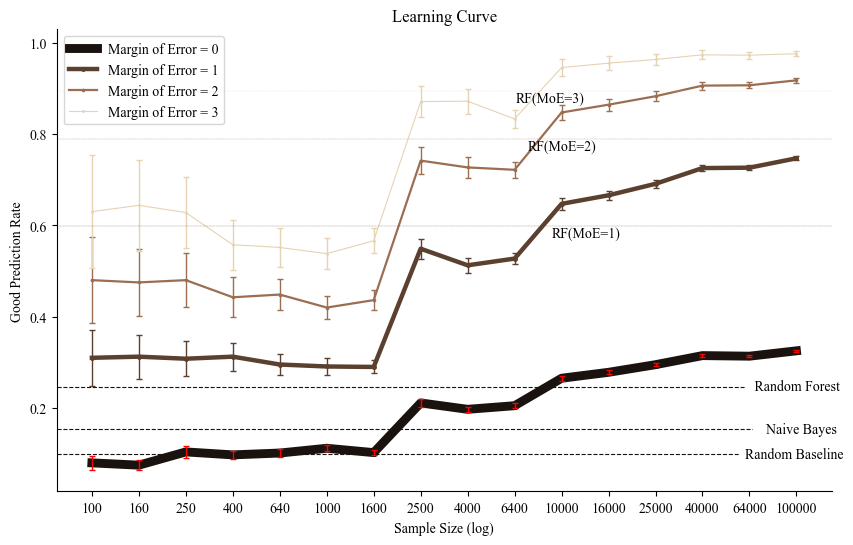

In [16]:
frequencies_re = [2000, 5675, 8927, 11761, 14176, 16176, 17761, 18927, 19675, 20000]
frequencies_nb = [3068, 8085, 11668, 14359, 16311, 17718, 18632, 19308, 19800, 20000]
frequencies_rf = [4940, 11950, 15758, 17882, 19011, 19573, 19840, 19946, 19993, 20000]

rt_error_pct = [p/20000 for p in frequencies_re]
nb_error_pct = [p/20000 for p in frequencies_nb]
rf_error_pct = [p/20000 for p in frequencies_rf]

moe_0 = [l[0] for l in them_errors]
moe_1 = [l[1] for l in them_errors]
moe_2 = [l[2] for l in them_errors]
moe_3 = [l[3] for l in them_errors]

std_0 = [l[0] for l in them_errors]
std_1 = [l[1] for l in them_errors]
std_2 = [l[2] for l in them_errors]
std_3 = [l[3] for l in them_errors]

n_0 = np.array(total_game_counts)

ci_95_0 = 1.96 * np.array(std_0) / np.sqrt(n_0)
ci_95_1 = 1.96 * np.array(std_1) / np.sqrt(n_0)
ci_95_2 = 1.96 * np.array(std_2) / np.sqrt(n_0)
ci_95_3 = 1.96 * np.array(std_3) / np.sqrt(n_0)

lab_0 = "Margin of Error = 0"
lab_1 = "Margin of Error = 1"
lab_2 = "Margin of Error = 2"
lab_3 = "Margin of Error = 3"
col_0 = "#1a120e"
col_1 = "#5b402f"
col_2 = "#9b6e51"
col_3 = "#e5d3b3"
graph_title = "Learning Curve"
x_label = "Sample Size (log)"
y_label = "Good Prediction Rate"
rt_val = rt_error_pct[0]
nb_val = nb_error_pct[0]
rf_val = rf_error_pct[0]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(moe_0, label=lab_0, color=col_0, linewidth=6.4, marker='o', markersize=4)
ax.plot(moe_1, label=lab_1, color=col_1, linewidth=3.2, marker='o', markersize=2.5)
ax.plot(moe_2, label=lab_2, color=col_2, linewidth=1.6, marker='o', markersize=1.6)
ax.plot(moe_3, label=lab_3, color=col_3, linewidth=0.8, marker='o', markersize=1)

ax.errorbar(range(len(n_0)), moe_0, yerr=ci_95_0, fmt='none', ecolor="red", capsize=2, elinewidth=1)
ax.errorbar(range(len(n_0)), moe_1, yerr=ci_95_1, fmt='none', ecolor=col_1, capsize=2, elinewidth=1)
ax.errorbar(range(len(n_0)), moe_2, yerr=ci_95_2, fmt='none', ecolor=col_2, capsize=2, elinewidth=1)
ax.errorbar(range(len(n_0)), moe_3, yerr=ci_95_3, fmt='none', ecolor=col_3, capsize=2, elinewidth=1)

ax.set_title(graph_title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_xticks(range(len(total_game_counts)))
ax.set_xticklabels(total_game_counts)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=rt_val, color=col_0, linestyle='--', linewidth=0.8)
ax.axhline(y=nb_val, color=col_0, linestyle='--', linewidth=0.8)
ax.axhline(y=rf_val, color=col_0, linestyle='--', linewidth=0.8)

ax.axhline(y=rf_error_pct[1], color=col_1, linestyle='--', linewidth=0.2)
ax.axhline(y=rf_error_pct[2], color=col_2, linestyle='--', linewidth=0.2)
ax.axhline(y=rf_error_pct[3], color=col_3, linestyle='--', linewidth=0.2)

ax.text(len(total_game_counts), rt_val, 'Random Baseline', va='center', ha='right', backgroundcolor='white')
ax.text(len(total_game_counts), nb_val, '  Naive Bayes  ', va='center', ha='right', backgroundcolor='white')
ax.text(len(total_game_counts), rf_val, ' Random Forest ', va='center', ha='right', backgroundcolor='white')
ax.text(len(total_game_counts)-4.75, rf_error_pct[1], 'RF(MoE=1)', va='top' , ha='right')
ax.text(len(total_game_counts)-5.25, rf_error_pct[2], 'RF(MoE=2)', va='top', ha='right')
ax.text(len(total_game_counts)-5.5, rf_error_pct[3], 'RF(MoE=3)', va='top', ha='right')

ax.legend()
plt.show()